In [ ]:
# Cell 1: Mount Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 2: Imports and seeds
import os
import random
import shutil
import itertools
import glob

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
import imutils
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [ ]:
# Cell 3: crop_img utility (safe cropping)
def crop_img(img, add_pixels=0):
    """
    Finds biggest contour's extreme points and crops the image safely.
    If no contour found, returns the original image copy.
    img: expected in RGB or BGR (any 3-channel)
    """
    if img is None:
        return None
    # ensure color
    if len(img.shape) == 2:
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img_color = img.copy()
    gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) == 0:
        return img_color.copy()

    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    h, w = img_color.shape[:2]
    x1 = max(0, extLeft[0] - add_pixels)
    x2 = min(w, extRight[0] + add_pixels)
    y1 = max(0, extTop[1] - add_pixels)
    y2 = min(h, extBot[1] + add_pixels)

    if x2 <= x1 or y2 <= y1:
        return img_color.copy()

    new_img = img_color[y1:y2, x1:x2].copy()
    return new_img


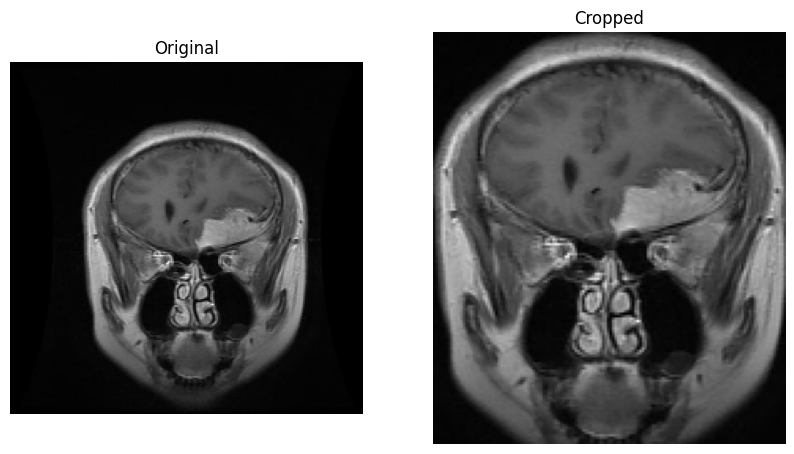

In [ ]:
# Cell 4: Demo crop on a single image (optional, run to visualize)
p = '/content/drive/My Drive/brain_tumour/Training/meningioma/Tr-meTr_0000.jpg'
img_bgr = cv2.imread(p)
if img_bgr is None:
    print("File not found:", p)
else:
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
    cropped = crop_img(img_resized)
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1); plt.imshow(img_resized); plt.title('Original'); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(cropped); plt.title('Cropped'); plt.axis('off')
    plt.show()


In [ ]:
# Cell 5: Load images into arrays (cropped folders expected)
# Adjust paths if your dataset is in different folder
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
image_size = 200  # your chosen size

train_base = '/content/drive/My Drive/brain_tumour/cropped/Training'
test_base  = '/content/drive/My Drive/brain_tumour/cropped/Testing'

x_train = []
y_train = []
x_test = []
y_test = []

for label in labels:
    trainPath = os.path.join(train_base, label)
    testPath  = os.path.join(test_base, label)

    if os.path.isdir(trainPath):
        for fname in tqdm(os.listdir(trainPath), desc=f"Loading train {label}"):
            fpath = os.path.join(trainPath, fname)
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)  # as your pipeline used grayscale then colormap
            if img is None:
                continue
            img = cv2.bilateralFilter(img, 2, 50, 50)
            img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)
            img = cv2.resize(img, (image_size, image_size))
            x_train.append(img)
            y_train.append(labels.index(label))
    else:
        print("Train path missing:", trainPath)

    if os.path.isdir(testPath):
        for fname in tqdm(os.listdir(testPath), desc=f"Loading test {label}"):
            fpath = os.path.join(testPath, fname)
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.bilateralFilter(img, 2, 50, 50)
            img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)
            img = cv2.resize(img, (image_size, image_size))
            x_test.append(img)
            y_test.append(labels.index(label))
    else:
        print("Test path missing:", testPath)

# convert to numpy arrays
x_train = np.array(x_train, dtype=np.uint8)
x_test  = np.array(x_test, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.int32)
y_test  = np.array(y_test, dtype=np.int32)

print("x_train shape:", x_train.shape)
print("x_test shape: ", x_test.shape)


Loading test pituitary: 100%|██████████| 300/300 [00:06<00:00, 44.50it/s] 


x_train shape: (5713, 200, 200, 3)
x_test shape:  (1311, 200, 200, 3)


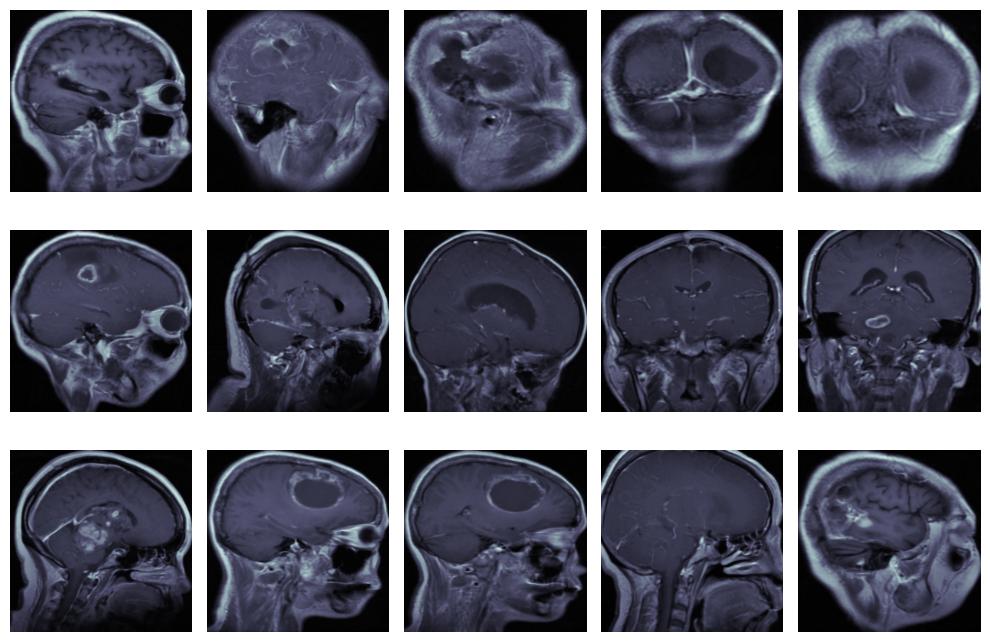

In [ ]:
# Cell 6: Visualize a few examples
n = min(15, x_train.shape[0])
fig, axes = plt.subplots(3, 5, figsize=(10, 7))
axes = axes.flatten()
for i, ax in enumerate(axes[:n]):
    ax.imshow(cv2.cvtColor(x_train[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Cell 7: Shuffle, one-hot encode and split
x_train, y_train = shuffle(x_train, y_train, random_state=SEED)

# one-hot encode
num_classes = len(labels)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat  = tf.keras.utils.to_categorical(y_test, num_classes)

# split validation from training
x_train, x_val, y_train_cat, y_val = train_test_split(
    x_train, y_train_cat, test_size=0.2, random_state=SEED, stratify=y_train
)

print("After split -> x_train:", x_train.shape, "x_val:", x_val.shape)


After split -> x_train: (4570, 200, 200, 3) x_val: (1143, 200, 200, 3)


In [ ]:
# Cell 8: Normalize strategy
# We will NOT pre-normalize x_train/x_val/x_test here.
# Instead we will use ImageDataGenerator(rescale=1./255) for training and apply /255 on validation/test when needed.

# Convert arrays to float32 to avoid dtype issues later
x_train = x_train.astype('float32')
x_val   = x_val.astype('float32')
x_test  = x_test.astype('float32')


In [ ]:
# Cell 9: ImageDataGenerator for training and simple generator for validation/test
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255  # scale here
)

# For validation/testing: only rescale
val_datagen = ImageDataGenerator(rescale=1./255)

# fit not strictly necessary for these transforms (no featurewise_center)
# train_datagen.fit(x_train)


In [ ]:
# Cell 10: Build model (ResNet50 base)
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

IMG_SIZE = (image_size, image_size, 3)

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SIZE)

# Option: freeze most layers, then fine-tune last blocks
for layer in base_model.layers:
    layer.trainable = True

# unfreeze last conv block for fine-tuning (optional)
for layer in base_model.layers[-30:]:
    layer.trainable = True

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

opt = Adam(learning_rate=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# CELL 11 — Recompile optimizer, prepare callbacks (modern .keras checkpoint)
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint_dir = '/content/drive/My Drive/brain_tumour'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'best_model.keras')

# Recreate optimizer and recompile (resets optimizer state)
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print("Model recompiled with Adam lr=1e-4")

# Callbacks: conservative reduce-lr and early stopping
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
]

# LR printer (optional; prints LR after each epoch)
class LRPrinter(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        try:
            lr_val = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        except Exception:
            try:
                lr_val = self.model.optimizer.learning_rate.numpy()
            except Exception:
                lr_val = str(self.model.optimizer.learning_rate)
        print(f"Epoch {epoch+1} — lr: {lr_val:.6e}")

callbacks.append(LRPrinter())

# Confirm current LR (robust)
try:
    current_lr = tf.keras.backend.get_value(model.optimizer.learning_rate)
except Exception:
    try:
        current_lr = model.optimizer.learning_rate.numpy()
    except Exception:
        current_lr = str(model.optimizer.learning_rate)
print("Current optimizer lr:", current_lr)


Model recompiled with Adam lr=1e-4
Current optimizer lr: 1e-04


In [ ]:
# CELL 12 — Train model
batch_size = 32   # change to 16 or 8 if you get OOM
epochs = 50

train_generator = train_datagen.flow(x_train, y_train_cat, batch_size=batch_size, shuffle=True)

# validation scaled (train_datagen uses rescale=1./255)
x_val_scaled = x_val / 255.0

history = model.fit(
    train_generator,
    steps_per_epoch=max(1, len(x_train) // batch_size),
    validation_data=(x_val_scaled, y_val),
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9881 - loss: 0.0381
Epoch 1: val_loss improved from 0.13593 to 0.07767, saving model to /content/drive/My Drive/brain_tumour/best_model.keras
Epoch 1 — lr: 5.000000e-05
142/142 ━━━━━━━━━━━━━━━━━━━━ 84s 588ms/step - accuracy: 0.9881 - loss: 0.0381 - val_accuracy: 0.9755 - val_loss: 0.0777 - learning_rate: 5.0000e-05
Epoch 2/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 43s 309ms/step - accuracy: 0.9688 - loss: 0.0590

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.07767
Epoch 2 — lr: 5.000000e-05
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9688 - loss: 0.0590 - val_accuracy: 0.9755 - val_loss: 0.0799 - learning_rate: 5.0000e-05
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9839 - loss: 0.0404
Epoch 3: val_loss did not improve from 0.07767
Epoch 3 — lr: 5.000000e-05
142/142 ━━━━━━━━━━━━━━━━━━━━ 68s 480ms/step - accuracy: 0.9839 - loss: 0.0404 - val_accuracy: 0.9781 - val_loss: 0.0885 - learning_rate: 5.0000e-05
Epoch 4/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 35s 252ms/step - accuracy: 0.9688 - loss: 0.0391
Epoch 4: val_loss did not improve from 0.07767

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 4 — lr: 2.500000e-05
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9688 - loss: 0.0391 - val_accuracy: 0.9781 - val_loss: 0.0873 - learning_rate: 5.0000e-05
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9915 - loss: 0.

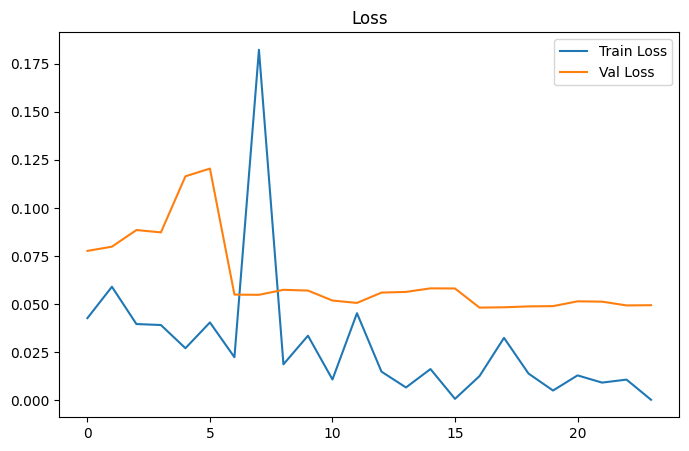

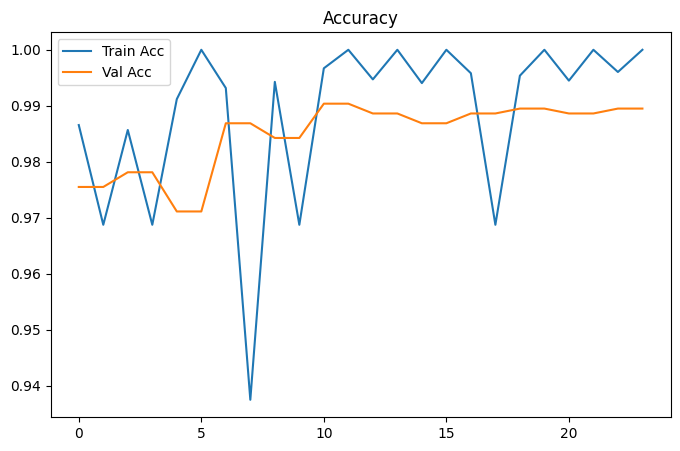

In [ ]:
# CELL 13 — Plot loss and accuracy curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss'); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy'); plt.show()


In [ ]:
# CELL 14 — Load best saved model and save a copy
from tensorflow.keras.models import load_model

best_model = load_model('/content/drive/My Drive/brain_tumour/best_model.keras')
print("Loaded best_model.keras")

best_model.save('/content/drive/My Drive/brain_tumour/model_resnet50_trained.keras')
print("Saved copy to model_resnet50_trained.keras")


Loaded best_model.keras
Saved copy to model_resnet50_trained.keras


In [ ]:
# CELL 15 — Evaluate on test set
x_test_scaled = x_test / 255.0
loss, acc = best_model.evaluate(x_test_scaled, y_test_cat, batch_size=32, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9899 - loss: 0.0622
Test Loss: 0.0346, Test Accuracy: 0.9931


In [ ]:
# CELL 16 — Classification report
import numpy as np
from sklearn.metrics import classification_report

pred_probs = best_model.predict(x_test_scaled, batch_size=32, verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(y_test_cat, axis=1)

print(classification_report(true_classes, pred_classes, target_names=labels))


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       300
  meningioma       0.99      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



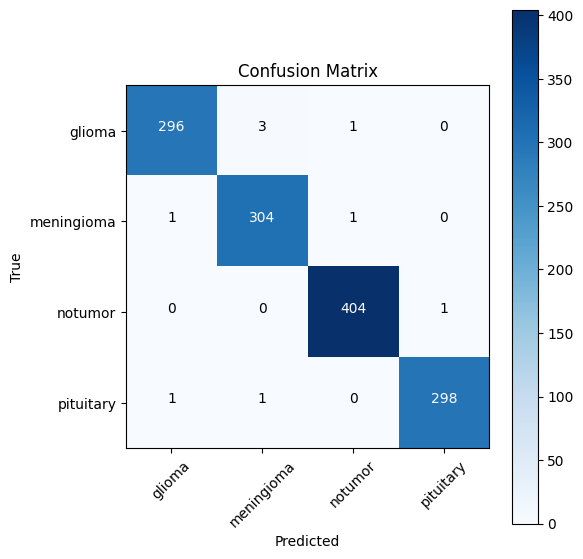

In [ ]:
# CELL 17 — Confusion matrix plot
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


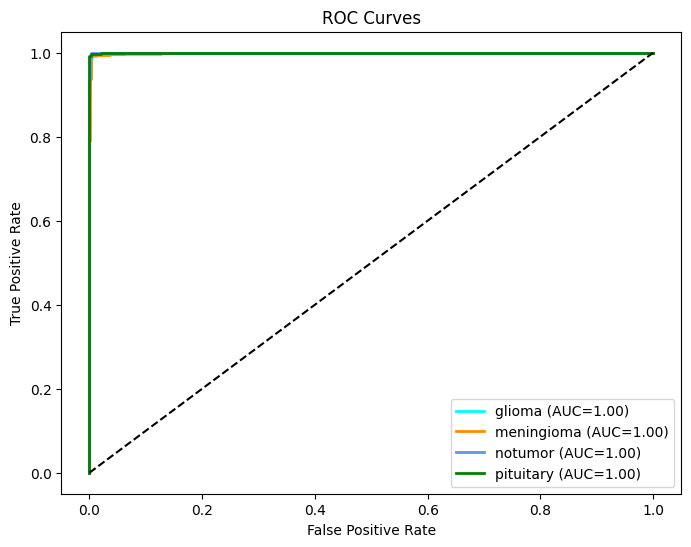

In [ ]:
# CELL 18 — ROC curves (one-vs-rest)
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt

n_classes = len(labels)
fpr = {}; tpr = {}; roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_cat.ravel(), pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
plt.figure(figsize=(8,6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"{labels[i]} (AUC={roc_auc[i]:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


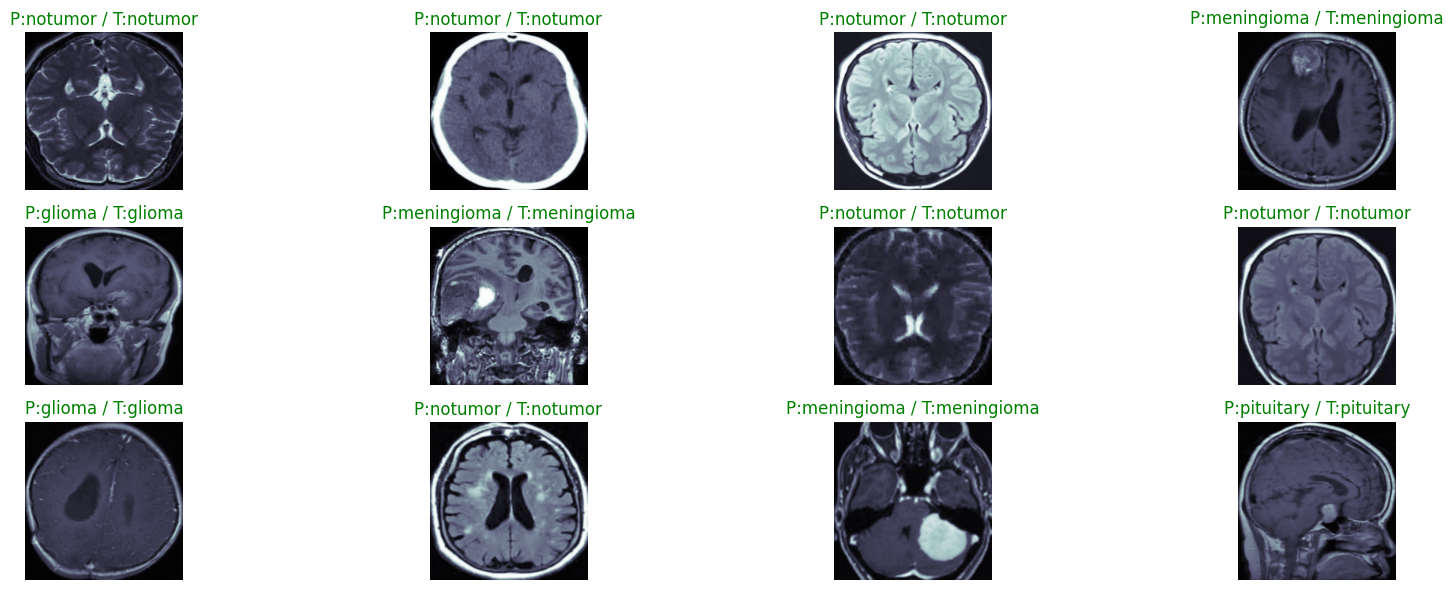

In [ ]:
# CELL 19 — Visualize random test predictions
import numpy as np
import matplotlib.pyplot as plt
import cv2

indices = np.random.choice(len(x_test_scaled), size=12, replace=False)
fig = plt.figure(figsize=(18,6))
for i, idx in enumerate(indices):
    ax = fig.add_subplot(3, 4, i+1)
    ax.imshow(cv2.cvtColor(x_test[idx].astype(np.uint8), cv2.COLOR_BGR2RGB))
    p = labels[pred_classes[idx]]
    t = labels[true_classes[idx]]
    ax.set_title(f"P:{p} / T:{t}", color=('green' if p==t else 'red'))
    ax.axis('off')
plt.tight_layout()
plt.show()
